In [1]:
from fastai.text import *
import pandas as pd
import lime.lime_text
import numpy as np
import webbrowser
import matplotlib.cm as cm
%matplotlib inline

#!pip install lime;

In [2]:
# Settings
path = 'data/Amazon_zip'
bs = 48

In [3]:
# Set seed for reproducible results
def random_seed(seed_value):
    
    import random 
    random.seed(seed_value) # Python
    
    import numpy as np
    np.random.seed(seed_value) # cpu vars
    
    import torch
    torch.manual_seed(seed_value) # cpu  vars
    torch.backends.cudnn.deterministic = True
    
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed_value)

## Language model

In [4]:
random_seed(42)
# Import data
data_lm = (TextList.from_folder(path)
           .filter_by_folder(include=['train', 'test', 'unsup'])
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs=bs, num_workers = 0))

In [5]:
# Print length of training and test data
print(len(data_lm.train_ds)+len(data_lm.valid_ds))

68995


In [6]:
# Save data for language model
data_lm.save('Amazon_lm_final.pkl')

In [4]:
random_seed(42)

# Load data for language model
data_lm = load_data(path, 'Amazon_lm_final.pkl', bs=bs, num_workers = 0)

In [8]:
# Show 5 batches of language model data
data_lm.show_batch()

idx,text
0,room was wonderful . xxmaj extremely large xxmaj king size bed with expansive sitting area . xxmaj we are used to smaller hotels with little room to move . xxmaj the bed was extremely comfortable with lots of pillows . xxmaj no wear or damage in room at all except sink tap dripped a bit ( poor taps ) . xxmaj we could have upgraded to river view for $
1,"have a xxmaj gluten xxmaj free xxmaj menu ! \n xxbos xxmaj awesome experience overall . xxmaj great food , very reasonable prices , top quality meats and exceptional service all around . xxmaj plus they have great sushi and oysters . xxmaj the manager , xxmaj xxunk , even gave us a tour of the kitchen . xxmaj thanks for the great experience ! \n xxbos xxmaj"
2,"as for the food , we started with the xxmaj lithuanian xxmaj bacon xxmaj buns - suggested since there are 3 to share . xxmaj these were probably the most surprising . xxmaj reminded me of hawaiian sweet rolls but with a meaty surprise stuffed in the middle . xxmaj served with homemade butter with salt and black pepper . xxmaj to be honest everything on the menu looked deliciously"
3,"the sauce on the side just kicked it up a notch . xxmaj oh the churros . i just want to curl up with one of those bad boys and lie there forever surrounded by fried dough and sugary goodness . xxmaj seriously , i could eat those everyday . xxmaj while the price point seems a little high ( $ 16 for a sandwich and guac ) the ingredients"
4,"i did not care for the chocolate ganache . xxmaj it smelled old like it was in the xxunk for a while and the texture was gross . xxmaj my boyfriend enjoyed his apple strudel though . \n xxbos xxmaj take my word , every city i visit i sniff out the best pizza like a blood hound . i eat pizza , its what i do and xxmaj"


In [5]:
# Examples of tokenised text
data_lm.train_ds[1][0]

Text xxbos xxmaj if i did n't have to stay here , i would n't . xxmaj without exception , i swear i am not lying , every day of my stay brings a new problem . xxmaj over the past 3 months , i have stayed here 6 times for 3 nights at a time ; problems every time . xxmaj from the wrong food with room service , to room keys that do nt work , xxunk bath towels , forgotten and dirty in - room coffee service , unclean ice bucket overnight , forgotten room cleaning , inability to connect to the xxmaj internet xxrep 4 . i 'm too tired to keep writing all the problems . xxmaj for the price of this chi - chi downtown hotel , i expect more . xxmaj finally , their team is certainly not trained in customer service . xxmaj the front desk teams have attitudes , and xxmaj aria 's hostesses think they are something else . i 'm stuck using this hotel since it is adjoined to xxmaj aon , but i would never go back if i had a choice . xxmaj the only good thing is the food at xxmaj aria - outstanding . 
 

In [6]:
# Examples of numericalised text
data_lm.train_ds[1][0].data[:10]

array([  2,   5,  56,  13,  76,  33,  38,  15, 263,  59])

In [7]:
random_seed(42)

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


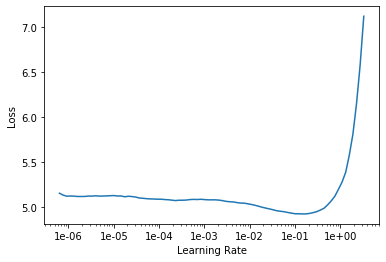

In [10]:
random_seed(42)

learn.lr_find()
learn.recorder.plot()

In [11]:
random_seed(42)

learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.825480,3.673603,0.309662,03:56


In [12]:
learn.save('AZ_fit_head_final')

In [13]:
random_seed(42)

learn.load('AZ_fit_head_final');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


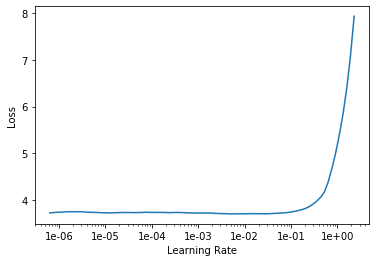

In [14]:
random_seed(42)

# Range tests
learn.lr_find()
learn.recorder.plot()

In [15]:
random_seed(42)

# Unfreeze all layers and train the model
learn.unfreeze()
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.531689,3.476721,0.332984,04:45
1,3.439922,3.387414,0.344281,04:47
2,3.368656,3.327221,0.351951,04:46
3,3.257593,3.290025,0.356770,04:47
4,3.171850,3.265356,0.360879,04:46
5,3.097724,3.252323,0.362994,04:47
6,3.010695,3.250881,0.363615,04:47
7,2.966153,3.254714,0.363553,04:46


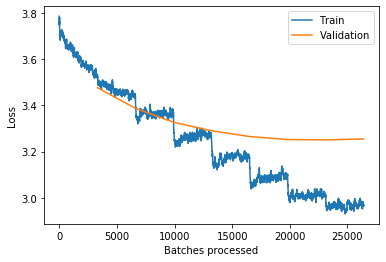

In [16]:
# Plot training and validation loss
learn.recorder.plot_losses()

In [17]:
# Save fine-tuned language model
learn.save('AZ_fine_tuned_final')

In [8]:
random_seed(42)

# Load fine-tuned language model
learn.load('AZ_fine_tuned_final');

In [44]:
# Check the English knowledge of the network by generating fake reviews.
TEXT = "I did not like this hotel because"
N_WORDS = 50
N_SENTENCES = 1
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.8) for _ in range(N_SENTENCES)))

I did not like this hotel because it is pretty busy and i was not able to take advantage of it . The rooms are small , and the bathroom has a huge tub consisting of huge toilet paper , flat screen TV , ipod dock , and a DVD player . The


In [24]:
# Save Encoder of the language model
learn.save_encoder('AZ_fine_tuned_enc_final')

## Classifier

In [6]:
random_seed(42)

# Show 5 entries of classifier data
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder()
             #label them all with their folders
             .databunch(bs=bs, num_workers=0))

In [300]:
# Save data for classification task
data_clas.save('AZ_data_clas_final.pkl')

In [7]:
# Show 5 entries of classifier data
data_clas.show_batch()

text,target
"xxbos i was very much looking forward to our stay at this hotel , after hearing all the good things about it . xxmaj unfortunately , it was a very underwhelming experience , to say the least . xxmaj but let me begin with the things that i do like about the hotel . xxmaj first off , it is located my favorite part of xxmaj chicago - the leafy",genuine
"xxbos xxmaj for a hotel rated with four diamonds by xxup aaa , one would think the xxmaj hilton xxmaj chicago would be almost like staying at a palace with royalty . xxmaj the only royal thing about this hotel however is that it was a royal nightmare . i should have known from the moment i walked in with my wife that this was going to become a bigger",deceptive
xxbos xxmaj this review has two parts . . xxup .i advise reading both . xxmaj chapter xxmaj one : xxmaj the actual hotel and staff i found the in house staff to be very friendly and accommodating . xxmaj the room was nice and clean as well . i have no disagreement with any of the other reviews regarding the hotel room or the staff . xxmaj this is,genuine
"xxbos xxmaj stay xxmaj away ! xxmaj after generations as an old - world , cozy and stately , if a bit tired oasis , the xxup ae has been purchased by xxmaj ian xxmaj schrager and taken down so many notches it 's almost not functional . xxmaj allowing for the fact that the hotel is under renovation , the entrance is not handicapped accessible , and i saw",genuine
"xxbos xxmaj avoid xxmaj the xxmaj talbot , especially for group functions . xxmaj my in - laws spent a great deal of time trying to find just the right hotel to use for our wedding party and several out of town guests . xxmaj they were lured in by promises from xxmaj the xxmaj talbot , that since they were a small boutique hotel that they could provide """,genuine


In [5]:
random_seed(42)

# Load classifier data
data_clas = load_data(path, 'AZ_data_clas_final.pkl', bs=bs, num_workers = 0)

# Check that vocabulary of language model is the same as the classfier vocabulary
len(data_clas.vocab.itos) == len(data_lm.vocab.itos)

True

In [6]:
random_seed(42)

# Initialise classifier model
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

# Load encoder into classifier
learn.load_encoder('AZ_fine_tuned_enc_final');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 4.37E-02


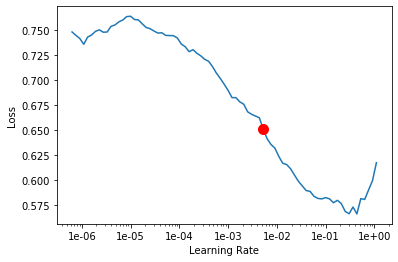

In [34]:
random_seed(42)

# Range test
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
random_seed(42)

# Keep frozen and train the head of the model
#learn.fit_one_cycle(9, 5e-4, moms=(0.8,0.7)) #8e-3
learn.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.479894,0.513916,0.831250,00:02


In [36]:
# Save model
learn.save('AZ_first_final')

In [37]:
random_seed(42)

# Load model
learn.load('AZ_first_final');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 1.32E-07


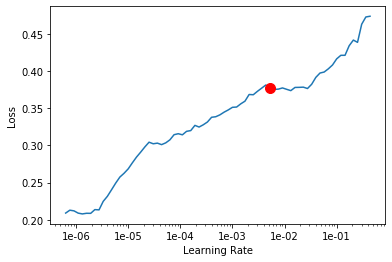

In [38]:
random_seed(42)

# Range test
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [40]:
random_seed(42)

# Unfreeze the last two layers groups and train the model
learn.load('AZ_first_final');
learn.freeze_to(-2)

learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-4), moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.256208,0.362801,0.853125,00:03


In [41]:
# Save model
learn.save('AZ_second_final')

In [42]:
random_seed(42)

# Load model
learn.load('AZ_second_final');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 6.31E-08


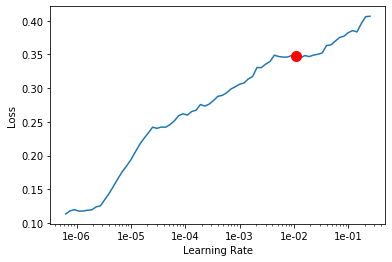

In [44]:
random_seed(42)

# Range test
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [45]:
random_seed(42)

# Unfreeze the last 3 layers group and train model
learn.load('AZ_second_final');
learn.freeze_to(-3)

learn.fit_one_cycle(1, slice(9e-3/(2.6**4),9e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.510376,0.328457,0.856250,00:04


In [46]:
# Save model
learn.save('AZ_third_final')

In [47]:
random_seed(42)

# Load model
learn.load('AZ_third_final');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 2.75E-07


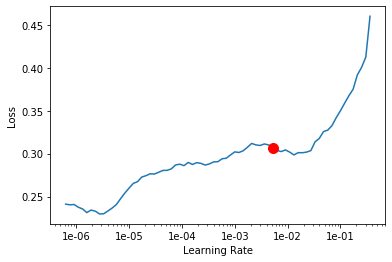

In [48]:
random_seed(42)

# Range test
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [54]:
random_seed(42)

# Unfreeze all layers group and train the model
learn.load('AZ_third_final');
learn.unfreeze()

learn.fit_one_cycle(4, slice(4e-3/(2.6**4),4e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.230893,0.300197,0.890625,00:05
1,0.217894,0.329669,0.868750,00:05
2,0.173970,0.319202,0.884375,00:05
3,0.134534,0.240911,0.915625,00:05


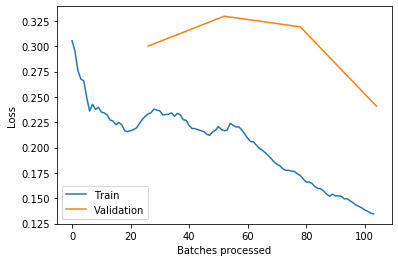

In [55]:
# Plot train and validation loss
learn.recorder.plot_losses()

In [72]:
# Save model
learn.save('AZ_final_model')
learn.export(file = 'amazon_review_classifier.pkl')

In [98]:
# Load the final model
#learn = load_learner('data/Amazon_zip', file = 'amazon_review_classifier.pkl')
learn.load('AZ_final_model');

In [99]:
# Check prediction of the model
learn.predict("If you are looking for a luxurious downtown Chicago experience, the Conrad Chicago is the place to stay. The rooms are equipped with the most comfortable beds dressed with the most luxurious bedding, a 42 inch flat screen television, a spa like bathroom with marble vanity and soaking tub, and views of downtown Chicago that will take your breath away. The hotel has many amenities for you to enjoy while you are there including great restaurants and bars, high speed internet, a fitness facility and laundry services. This hotel was a great place to stay and I would recommend it to anyone looking for a high quality place to stay in downtown Chicago.")

# Here it returns the predicted class 'deceptive', which corresponds to a label of 0. 
# The probabilities the model found for each class are 9.9995e-01 and 5.3935e-05 respectively, so its confidence is pretty high.

(Category deceptive, tensor(0), tensor([9.9995e-01, 5.3935e-05]))

# Model metrics and interpretation

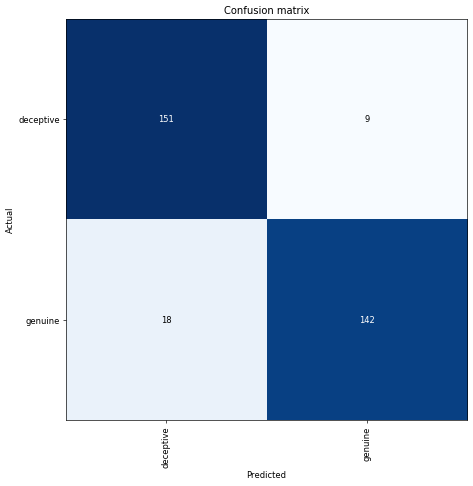

In [96]:
learn.load('AZ_final_model')
interp_metrics = ClassificationInterpretation.from_learner(learn)

# Confusion matrix
interp_metrics.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [68]:
# Load final model
learn.load('AZ_final_model');

preds,y,losses = learn.get_preds(with_loss=True, ordered=True)
preds_round = np.argmax(preds, axis=1)
erroneous_label = preds_round!= y

In [72]:
data = learn.data.valid_ds
error_results = zip(data[erroneous_label], preds[erroneous_label])

In [73]:
print(tuple(error_results))

(((Text xxbos xxmaj my daughter and i woke in the morning wanting to go swimming . xxmaj when we arrived at the pool the water was covered by a white scum . i then attempted to use both of the phones at the pool , one white phone and one emergency red phone , to call the desk . xxmaj both were out of service xxrep 4 ! i am glad there was n't an emergency . xxmaj as we were exited the pool area i ran into a hotel employee and told her about the problems and then asked her to call us when the pool was clean xxrep 4 . never heard back . 
 , Category genuine), tensor([0.8880, 0.1120])), ((Text xxbos xxmaj my husband and i were in the xxmaj fairmont xxmaj chicago recently for a conference . xxmaj we stayed in a spacious suite . xxmaj all amenities appeared recently updated and in excellent shape . xxmaj the bed was very comfortable . xxmaj views were great . i love their products in the bathroom and used them in the pristine tub two out of three nights . xxmaj the room was so quiet , it was

In [77]:
learn.predict('xxbos xxmaj my daughter and i woke in the morning wanting to go swimming . xxmaj when we arrived at the pool the water was covered by a white scum . i then attempted to use both of the phones at the pool , one white phone and one emergency red phone , to call the desk . xxmaj both were out of service xxrep 4 ! i am glad there was n\'t an emergency . xxmaj as we were exited the pool area i ran into a hotel employee and told her about the problems and then asked her to call us when the pool was clean xxrep 4 . never heard back .')


(Category deceptive, tensor(0), tensor([0.9001, 0.0999]))

In [63]:
# Tabulation showing the first k texts in top_losses along with their prediction, actual,loss, 
# and probability of actual class. max_len is the maximum number of tokens displayed. 
# If max_len=None, it will display all tokens.

#txt_ci.show_top_losses(5)

In [49]:
#test_text = 'I stayed at the Fairmont Chicago for one night - I\'m a frequent business traveler and am very familiar with travel rituals. I checked in late (almost 10pm) due to flight cancellations from my home airport -- Atlanta. I took the shuttle to the airport (best option in lieu of the over priced taxis), and it was my first time staying at the hotel. Upon arrival, I immediately noticed the entrance, which appeared very welcoming and warm to me.I checked in with no problems -- and the desk person even asked if I\'d prefer a king or double (reconfirming my reservation preference). I always take the king when I can, and the bed was fantastic! It was suited with great linen and these incredible down & feather pillows named Encompass made by The Pillow Factory -- I checked the tags, since I plan to buy some! I ate dinner at the hotel restaurant - Aria, which they mention they like to be considered separate from the hotel -- and YES, it does stand out all on it\'s own.The food is Asian fusion, and truly wonderful -- as a gourmand and life-long foodie, I appreciate great food when I taste it! The hotel service was good as well. Only drawback was the breakfast buffet at the restaurant -- seems they need to stick with their dinner theme solely. They missed the mark on relatively simply things like scrambled eggs on the buffet, which tasted a bit \'metallic\'. But they made up for it by getting a special order made immediately after I passed on the buffet. I would highly recommend this hotel -- it has atmosphere and a great view (if you can get a room with one), fabulous dinner -- just pass on the breakfast buffet.'
#test_text = 'My stay at the Fairmont Chicago Millennium Park Hotel was by far the worst hotel stay I ever had. I would not recommend this hotel to anyone. They promised I would be able to relax in the spa area and it was dirty and not relaxing at all. When I got to my room I ordered room service and it took them 45 minutes to bring what I ordered. I am highly dissatisfied.'
#test_text = 'The Conrad Hotel is a beautiful hotel. Our room was perfect and beautiful in every way. I was very impressed (and I am hard to please and have high standards). It was so clean, aesthetically pleasing, up to date, just gorgeous! I would definitely stay there again. I loved it. The location is superb too, attached to Nordstrom and Northbridge mall. Can\'t wait to go back!'

In [107]:
#pred = learn.predict(data)
#pred

(Category deceptive, tensor(0), tensor([0.9962, 0.0038]))

## Classification interpretation

In [7]:
learn.load('AZ_final_model');

In [8]:
# Initialise Classification Interpretation class
txt_ci = TextClassificationInterpretation.from_learner(learn)

### Sequential Jacobian

In [9]:
#test_text = 'If you are looking for a luxurious downtown Chicago experience, the Conrad Chicago is the place to stay. The rooms are equipped with the most comfortable beds dressed with the most luxurious bedding, a 42 inch flat screen television, a spa like bathroom with marble vanity and soaking tub, and views of downtown Chicago that will take your breath away. The hotel has many amenities for you to enjoy while you are there including great restaurants and bars, high speed internet, a fitness facility and laundry services. This hotel was a great place to stay and I would recommend it to anyone looking for a high quality place to stay in downtown Chicago.'
# Deceptive example
deceptive_text = 'The Talbott Hotel was very classy, professional, and luxurious. I loved how the staff was nice and respectful. I was treated like i was royalty when i was there, when in checked i was greeted by all of the people working behind the front desk and was offered a tour of the hotel. They took my bags and put them in my room while i was taking the tour and they even escorted me to my room right after we were done. This is a very nice and modern looking and their rooms are spacious and clean unlike other hotels in their area. I have recommended this hotel to all of my family and friends and would recommend it to anyone who is going to stay in that area.'

genuine_text = 'My wife and I trvelled to Chicago and really were treated like royalty by the hotel staff! (My brother and his wife also stayed during this period.) The front desk staff, the concierge, the Star Bucks server, the restaurant, the lounge servers . . . all were wonderful! The rooms were spacious and the flat screen tv was really great! The bath room was a real plus ... it was huge and had everything one desires. Great view from 20th floor to Michigan Avenue below! Overall, great stay and highly recommended!'

In [10]:
# Deceptive example
txt_ci.show_intrinsic_attention(deceptive_text,cmap=cm.Purples)

/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


In [11]:
# Genuine example
txt_ci.show_intrinsic_attention(genuine_text,cmap=cm.Purples)

/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


In [12]:
# Raw attention values (uncomment to get intrinsic attention matrix)
txt_ci.intrinsic_attention(deceptive_text)[1]

/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


tensor([0.1956, 0.1123, 0.1639, 0.1330, 1.0000, 0.1879, 0.3787, 0.1130, 0.1193,
        0.2308, 0.0534, 0.2114, 0.0420, 0.0515, 0.1472, 0.0468, 0.0718, 0.1566,
        0.1419, 0.0908, 0.1861, 0.0585, 0.0978, 0.0505, 0.1927, 0.0487, 0.0662,
        0.0913, 0.2616, 0.0915, 0.0713, 0.0646, 0.2728, 0.1513, 0.0903, 0.0909,
        0.0505, 0.0454, 0.0903, 0.1329, 0.3615, 0.1340, 0.0660, 0.2328, 0.0810,
        0.1068, 0.0420, 0.0537, 0.1363, 0.1646, 0.1209, 0.0723, 0.1349, 0.1671,
        0.0522, 0.0743, 0.1994, 0.0999, 0.5139, 0.0525, 0.0540, 0.1580, 0.0356,
        0.0442, 0.0667, 0.1277, 0.1144, 0.4071, 0.0540, 0.1249, 0.0624, 0.0482,
        0.0744, 0.0926, 0.0560, 0.0383, 0.0291, 0.0945, 0.0373, 0.2552, 0.0212,
        0.0315, 0.0629, 0.1963, 0.0722, 0.0357, 0.0482, 0.0910, 0.0830, 0.0672,
        0.0436, 0.0322, 0.0469, 0.0218, 0.0518, 0.0941, 0.0849, 0.0845, 0.1661,
        0.1198, 0.0439, 0.0977, 0.0917, 0.0306, 0.0846, 0.1230, 0.0441, 0.1316,
        0.0283, 0.1136, 0.1448, 0.0821, 

In [13]:
txt_ci.intrinsic_attention(genuine_text)[1]

/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


tensor([0.2687, 0.1139, 0.1556, 0.2767, 0.0861, 0.1196, 0.6900, 0.1996, 0.1173,
        0.3083, 0.1339, 0.2481, 0.1066, 0.2639, 0.1060, 0.3433, 0.0667, 0.0720,
        0.1868, 0.1497, 0.0875, 0.1032, 0.0625, 0.0821, 0.1813, 0.0524, 0.0808,
        0.1070, 0.0674, 0.1566, 0.1158, 0.0566, 0.0841, 0.0400, 0.1566, 0.0648,
        0.1418, 0.2732, 0.2730, 0.2670, 0.1379, 0.2546, 0.7791, 0.2202, 0.2048,
        0.1931, 1.0000, 0.1934, 0.2821, 0.1836, 0.0921, 0.1025, 0.2190, 0.0828,
        0.1234, 0.3170, 0.1424, 0.0881, 0.1292, 0.1165, 0.0910, 0.0565, 0.0964,
        0.0525, 0.0242, 0.0579, 0.2071, 0.0858, 0.2034, 0.0483, 0.0877, 0.3139,
        0.2408, 0.1734, 0.0482, 0.0636, 0.0405, 0.0390, 0.0301, 0.1008, 0.6132,
        0.1688, 0.0889, 0.0806, 0.2153, 0.1652, 0.1216, 0.0847, 0.0547, 0.1401,
        0.0662, 0.1479, 0.2213, 0.1597, 0.1589, 0.0335, 0.0538, 0.2795, 0.5574,
        0.2525, 0.8450, 0.4139, 0.2186, 0.1769, 0.3234, 0.0403, 0.0722, 0.0383,
        0.0334, 0.0263, 0.1243, 0.0726, 

### LIME

In [14]:
def predict_fn(txt):
    #x = img.convert('RGB')
    #test_img = Image(pil2tensor(x, np.float32).div_(255))
    pred_class, pred_idx, outputs = learn.predict(txt)
    #print (pred_class)
    return outputs.numpy()#my_softmax(preds)

def softmax(x):
    tmp = np.zeros_like(x)
    """Compute softmax values for each sets of scores in x."""
    for i in range(x.shape[0]):
        s = np.exp(x[i, :])/np.sum(np.exp(x[i, :]))
        tmp[i, :] = s
    return tmp # only difference

def batch_predict(text):
    for i, img in enumerate(text):
        output = predict_fn(img)
        #print (output)
        if i == 0:
            preds = output
        else:
            preds = np.concatenate((preds, output), axis=0 )
    return softmax(preds.reshape(-1, len(data_clas.classes)))

In [15]:
# Classes
review_classes = data_clas.classes

In [16]:
# Tokenize text in the same way it enters the model
tokenizer = Tokenizer()
tok = SpacyTokenizer('en')
processed_deceptive_text = ' '.join(tokenizer.process_text(deceptive_text, tok))
processed_genuine_text = ' '.join(tokenizer.process_text(genuine_text, tok))

In [17]:
# Initialise the LIME explainer
explainer = lime.lime_text.LimeTextExplainer(class_names=review_classes)

In [18]:
exp_genuine = explainer.explain_instance(processed_genuine_text, classifier_fn=batch_predict)
exp_deceptive = explainer.explain_instance(processed_deceptive_text, classifier_fn=batch_predict)

In [21]:
exp_genuine.as_list()

[('xxmaj', 0.014694362375043471),
 ('chicago', -0.012607724080842623),
 ('concierge', 0.010509102757533771),
 ('front', 0.010141872969522946),
 ('lounge', 0.00814207518684269),
 ('wife', -0.007496464979925075),
 ('floor', 0.006377988369959841),
 ('desk', 0.006265209406657775),
 ('overall', -0.0058048709207228705),
 ('highly', -0.0039743528852231496)]

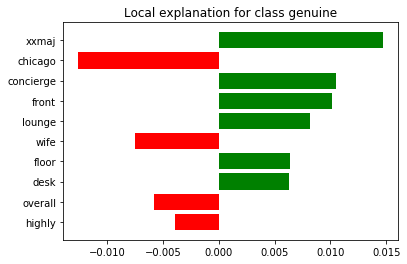

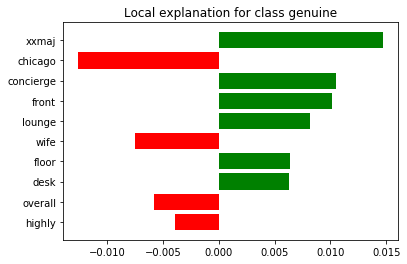

In [22]:
exp_genuine.as_pyplot_figure()

In [19]:
exp_genuine.show_in_notebook(text=True)

In [20]:
exp_deceptive.show_in_notebook(text=True)

# Robustness checks

### System architecture without pre-training
#### (i.e. LSTMs classifier from scratch)

In [111]:
random_seed(42)

# Load classifier data
data_clas = load_data(path, 'AZ_data_clas_final.pkl', bs=bs, num_workers = 0)

In [121]:
random_seed(42)

# Learner
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained = False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 3.63E-04


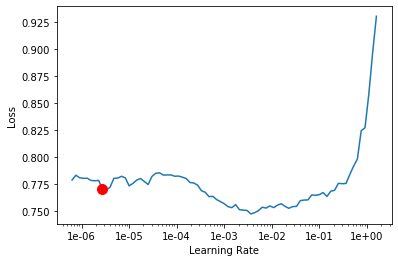

In [113]:
# Training
random_seed(42)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [122]:
random_seed(42)
learn.fit_one_cycle(7, 3e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.762056,0.692856,0.496875,00:05
1,0.712468,0.678673,0.709375,00:05
2,0.606793,0.718235,0.550000,00:05
3,0.476310,0.685371,0.634375,00:05
4,0.368825,0.320614,0.878125,00:05
5,0.280720,0.354578,0.840625,00:05
6,0.227838,0.298436,0.871875,00:05


### System architecture without optimisation 
#### (i.e. no discrimative learning rate and no freezing)

In [91]:
random_seed(42)

# Load classifier data
data_clas = load_data(path, 'AZ_data_clas_final.pkl', bs=bs, num_workers = 0)

In [92]:
random_seed(42)

# Learner
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.02E-02


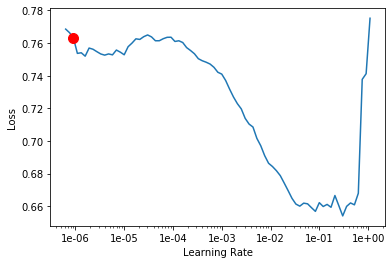

In [93]:
# Training
random_seed(42)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [94]:
random_seed(42)
learn.fit_one_cycle(7, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.667064,0.692660,0.493750,00:02
1,0.607788,1.027570,0.500000,00:02
2,0.557703,0.664502,0.537500,00:02
3,0.505621,0.870320,0.550000,00:02
4,0.444170,0.471207,0.771875,00:02
5,0.375787,0.542826,0.762500,00:02
6,0.322542,0.513955,0.784375,00:02


### System architecture without dropout 

In [95]:
# Remove dropout
config = awd_lstm_clas_config.copy()
config['hidden_p'] = 0
config['input_p'] = 0
config['embed_p'] = 0
config['weight_p'] = 0

In [96]:
learn = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 3.02E-02


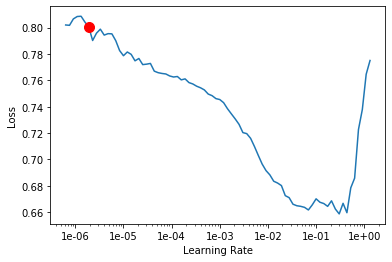

In [97]:
random_seed(42)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [98]:
random_seed(42)
learn.fit_one_cycle(7, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.644811,0.691949,0.562500,00:02
1,0.575624,0.918966,0.500000,00:02
2,0.543519,0.614498,0.693750,00:02
3,0.496057,0.567513,0.687500,00:02
4,0.431081,0.470606,0.796875,00:02
5,0.368822,0.499591,0.787500,00:02
6,0.310642,0.511205,0.812500,00:02
